# Fundamental questions

## Question 1: what level of granularity?

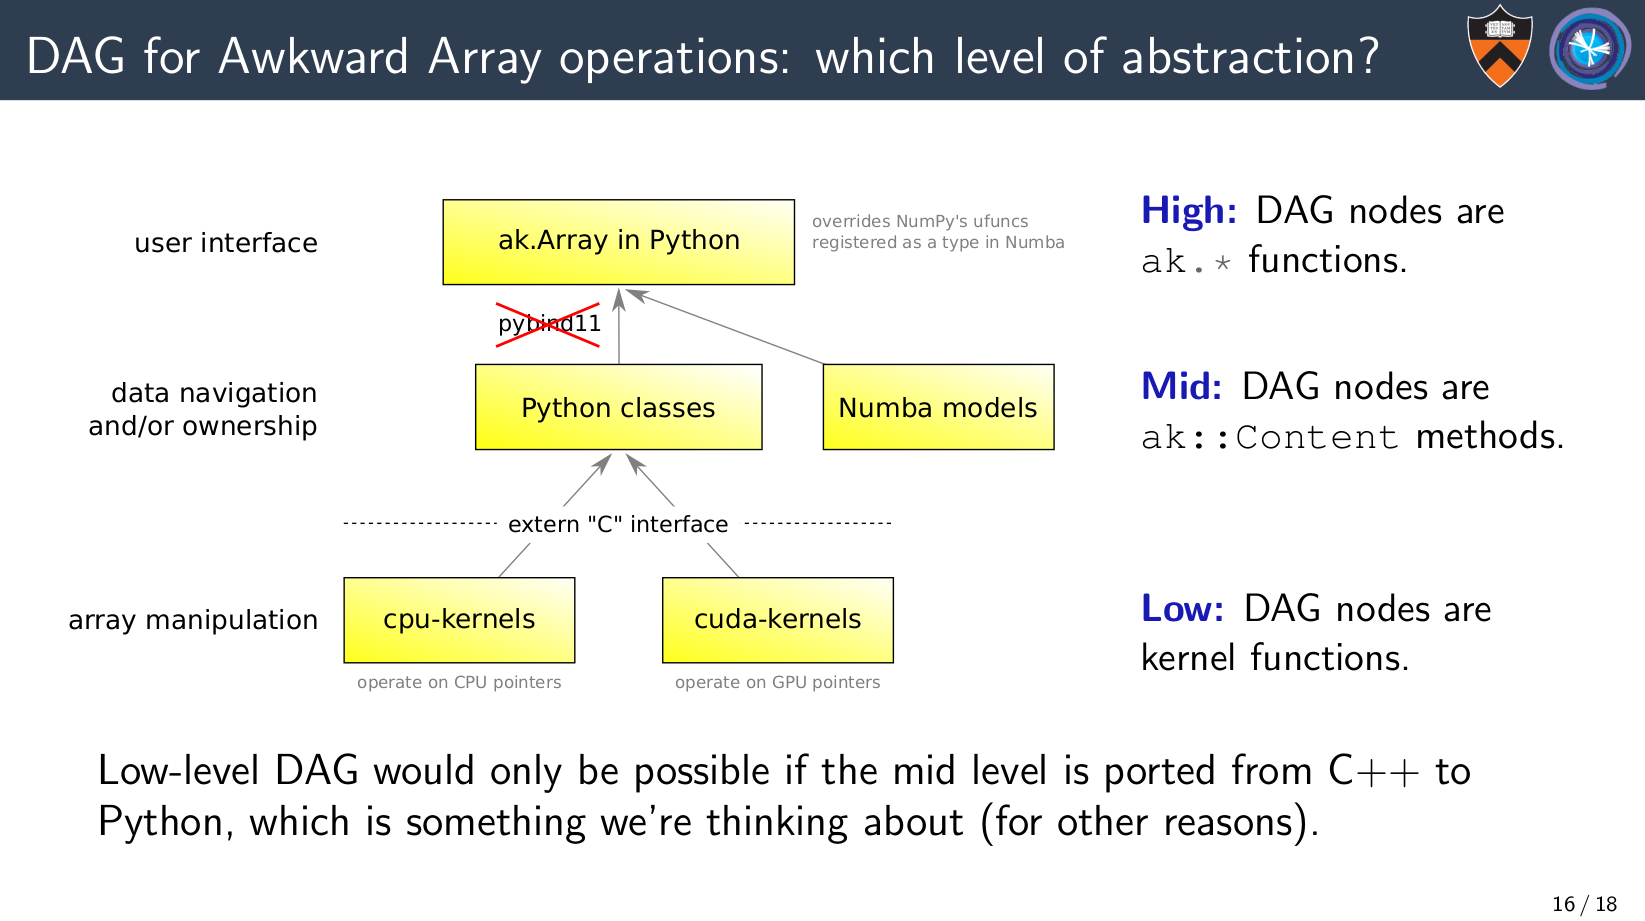

## Question 2: what information must be known before `.compute()`?

<p style="font-size: 36px; margin-left: 100px">These questions are coupled!</p>

## Option 1: "User-level DAG"

The nodes are either `ak.*` function calls or `Content` methods ("high" or "mid" in the slide above). The data types in these functions are `Content` trees and basic Python objects (e.g. slices, ints).

Information that could be available before `.compute()`:

   * Just Python type: `ak.Array` vs `ak.Record` vs number/bool vs `None`. Not only too little information, but it couldn't be determined without Awkward Type anyway.
   * Awkward Type: e.g. `var * int32`, but not distinctions between `ListArray` and `ListOffsetArray`. This is what the user wants to know and it _might_ be possible to propagate, but it would likely duplicate a lot of logic.
   * Awkward Form: e.g. distinctions betwen `ListArray` and `ListOffsetArray` (the level of detail needed for Numba). This _can't_ be propagated without duplicating a lot of logic.
   * Lengths of all of the above.

### Advantages

This is the level of granularity that users care about. If they ever had to see the names of these DAG nodes, `ak.whatever` would provide a lot more information than `awkward_internal_kernel_name`.

Other Dask projects operate at this level: `dask.array` and `dask.frame` (I don't know about xarray).

### Disadvantages

I don't see a way around duplicating logic: `Content` trees are more complex than either NumPy arrays or Pandas DataFrames. Each operation involves multiple type-changing steps; there is no top-down type information for each operation. If we create such a thing—static-typing a codebase that is currently dynamic—that type prediction will have to be kept in sync with the existing codebase.

"Static typing Awkward Array" sounds like a noble pursuit, but it's not a need that we're being driven to by user requests; it would only be for solving the Awkward-Dask problem _in this way_.

Two historical notes:

   1. The main difference between OAMap and Awkward Array was the decision to "go bottom-up," to encode the type implicitly in the array and manipulate them dynamically: stopping with an exception when types don't match, rather than OAMap's "top-down," schema-first approach. _I like static typing!_ But imposing it didn't solve user problems.
   2. Anish attempted to integrate Awkward Array and JAX in this top-down way: JAX saw the `Content` trees (as PyTrees). This was very difficult, as we had to be predicting types every time an array was sliced. Even though we approached the problem by performing a slice on a dummy array, we still ran into fundamental blockers. _It was this experience that motivated Awkward v2._ We're translating Awkward's middle layer from C++ to Python _specifically so that_ JAX, Dask, and other Python libraries can be kernel-level.

## Option 2: "kernel-level DAG" (nodes are 1D array operations)

The nodes are NumPy (or CuPy, etc.) function calls, array method calls, and Awkward kernel calls. The data types in these functions are _all_ rectilinear arrays. It might be possible to directly use `dask.array` in the implementation.

Information that could be available before `.compute()`:

   * `dtype` of the arrays
   * `ndim` of the arrays (like Numba)
   * `shape` information, either `shape[1:]` (which is usually `()`) or including `shape[0]`, but the latter would be difficult. Some steps in an `ak.*` function _compute_ lengths from values in the data. Think "slicing with a boolean array."

(I think that `dtype` and `ndim` only is the right level, and the demo implementation does that.)

### Advantages

Awkward Array can continue to be "bottom up," going with the flow of the overall design.

We only need to predict type transformations on the rectilinear arrays, which `dask.array` already does for NumPy.

If there are any difficulties passing a "tracer" object through the v2 code, _we want to fix that_ because we'll need to pass JAX tracers through, too. It's intentional timing that v2 is still in development—if we need to refactor it, now is the time.

Thinking ahead to the GPU implementation: if we simply replace cpu-kernels for cuda-kernels, they'll still be eagerly evaluated, so Python would be an unnecessary synchronization point between GPU function calls. I'm worried that that will be a design flaw. To remove Python from the runtime workflow, we'll need to build a DAG of cuda-kernel calls, which I'm hoping to get from Dask—but Dask would have to operate at the kernel level for that.

### Disadvantages

This is different from `dask.array` and `dask.frame`, which have Dask objects at the topmost level, visible to the user. Instead, the Dask objects would be hidden inside the `Content` tree as the "array" backing for `ak._v2.index.Index` and `ak._v2.contents.NumpyArray`. It might be less clear how to apply Dask Distributed machinery to it.

I think this is how xarray works, with Dask "hidden inside" an xarray.

### The same for both options

I think both options have equal potential for optimization. In both cases, fusing the DAG nodes that can run on the same worker will be essential, as most Awkward Array work is more elementwise/embarrassingly parallel than shuffle/join. Specifically, only `axis=0` (or `axis=None`) operations can have any dependencies across partitions, and for most operations, `axis=1` or `axis=-1` are the common cases.

For a "kernel-level DAG," however, fusing operations becomes even more important because there will be so many of them.

## Prototype of option 2: "kernel-level DAG"

I wrote a prototype in [ContinuumIO/dask-awkward#1](https://github.com/ContinuumIO/dask-awkward/pull/1), which requires [scikit-hep/awkward-1.0#1095](https://github.com/scikit-hep/awkward-1.0/pull/1095) (both are draft PRs).

I don't have a deep knowledge of Dask. I made DAGs that look like the plain dict examples on [https://docs.dask.org/en/latest/high-level-graphs.html](https://docs.dask.org/en/latest/high-level-graphs.html):

```python
{
 ('read-csv', 0): (pandas.read_csv, 'myfile.0.csv'),
 ('read-csv', 1): (pandas.read_csv, 'myfile.1.csv'),
 ('read-csv', 2): (pandas.read_csv, 'myfile.2.csv'),
 ('read-csv', 3): (pandas.read_csv, 'myfile.3.csv'),
 ('add', 0): (operator.add, ('read-csv', 0), 100),
 ('add', 1): (operator.add, ('read-csv', 1), 100),
 ('add', 2): (operator.add, ('read-csv', 2), 100),
 ('add', 3): (operator.add, ('read-csv', 3), 100),
 ('filter', 0): (lambda part: part[part.name == 'Alice'], ('add', 0)),
 ('filter', 1): (lambda part: part[part.name == 'Alice'], ('add', 1)),
 ('filter', 2): (lambda part: part[part.name == 'Alice'], ('add', 2)),
 ('filter', 3): (lambda part: part[part.name == 'Alice'], ('add', 3)),
}
```

and I made a `run` function that computes them. I know all of this exists in the main Dask codebase, and I think a proper implementation will be able to leverage a lot of existing Dask infrastructure. But I couldn't have written a prototype quickly enough while also learning the Dask codebase.

In [1]:
import awkward as ak
import numpy

Internally, Awkward Array gets access to NumPy _exclusively_ through an "nplike" object, and the same "nplike" provides access to kernels, so that cpu-kernels will be used with NumPy arrays and cuda-kernels will be used with CuPy arrays.

In [2]:
nplike = ak.nplike.of(numpy.array([1, 2, 3]))
nplike

In [3]:
np = ak.nplike.NumpyMetadata.instance()
np

In [4]:
buffer = nplike.zeros(10, np.int64)
buffer

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

This is a kernel named "awkward_localindex", specialized for 64-bit buffers. It's a holdover from v1 (will be replaced by `nplike.arange`), but serves to show how the mechanics work.

In [5]:
nplike["awkward_localindex", np.int64]

<NumpyKernel awkward_localindex, int64>

Kernels operate purely by side-effect (like CUDA kernels). The struct it returns has error information.

In [6]:
err = nplike["awkward_localindex", np.int64](buffer, 5)
err.str is None

True

In [7]:
buffer

array([0, 1, 2, 3, 4, 0, 0, 0, 0, 0])

The idea is that Dask is another library providing array-like objects, so it has its own "nplike".

This "nplike" is a Dask tracer, and the delayed arrays are the array objects associated with it.

In [8]:
from dask_awkward.kernel_level import *

In [9]:
dasklike = DaskTrace.instance()

In [12]:
buffer = dasklike.zeros(10, np.int64)
buffer

In [13]:
err = dasklike["awkward_localindex", np.int64](buffer, 5)
err

In [14]:
buffer.mutations

To transform it to a Dask-friendly graph of callables, references, and other objects, we have to give it the NumPy "nplike".

In [23]:
graph = buffer.graph(nplike)

for k, v in graph.items():
    print(f"{str(k):45} \u2192 {v}")

('zeros', 139806962981040)                    → (<function mutations at 0x7f273806f5e0>, ('zeros:raw', 139806962981040), ('awkward_localindex:int64', 139806963099584))
('zeros:raw', 139806962981040)                → (<bound method NumpyLike.zeros of <awkward.nplike.Numpy object at 0x7f2750086af0>>, 10, <class 'numpy.int64'>)
('awkward_localindex:int64', 139806963099584) → (<NumpyKernel awkward_localindex, int64>, ('zeros:raw', 139806962981040), 5)


This is now in executable form.

In [24]:
run(graph, buffer.id)

array([0, 1, 2, 3, 4, 0, 0, 0, 0, 0])

So far, I haven't shown much more than what `dask.array` already does (much better, I'm sure!).

The only addition is that Awkward kernels are among the functions that can act on these 1D arrays.

My point is that this is pretty much all we need to build a Dask-Awkward implementation that doesn't need to predict how high-level types will change in each operation. With these delayed arrays replacing NumPy/CuPy arrays, the Awkward Array codebase manipulates metadata as it already does; it just passes these delayed arrays through instead of concrete data.

That is, Awkward Array becomes an application that runs on Dask, rather than an API that Dask emulates.

In Awkward Array, 1D buffers for structure information are wrapped in `Index`.

In [29]:
offsets = ak._v2.index.Index(dasklike.asarray(numpy.array([0, 3, 3, 5])))
offsets

<Index dtype='int64' len="?">[delayed]</Index>

The only other node type that takes array data is called `NumpyArray`. These arrays are _usually_ 1D, but always rectilinear. (That was the motivation for the name.)

In [31]:
content = ak._v2.contents.NumpyArray(dasklike.asarray(numpy.array([1.1, 2.2, 3.3, 4.4, 5.5])))
content

<NumpyArray dtype='float64' len="?">[delayed]</NumpyArray>

Everything after `Index` and `NumpyArray` is metadata. Putting these in a `ListOffsetsArray` effectively makes

```python
[[1.1, 2.2, 3.3], [], [4.4, 5.5]]
```

In [32]:
listarray = ak._v2.contents.ListOffsetArray(offsets, content)
listarray

<ListOffsetArray len="?">
    <offsets><Index dtype='int64' len="?">[delayed]</Index></offsets>
    <content><NumpyArray dtype='float64' len="?">[delayed]</NumpyArray></content>
</ListOffsetArray>

For comparison, this is what the eagerly-evaluated version would look like:

In [33]:
ak._v2.tmp_for_testing.v1_to_v2(ak.from_iter([[1.1, 2.2, 3.3], [], [4.4, 5.5]], highlevel=False))

<ListOffsetArray len='3'>
    <offsets><Index dtype='int64' len='4'>[0 3 3 5]</Index></offsets>
    <content><NumpyArray dtype='float64' len='5'>[1.1 2.2 3.3 4.4 5.5]</NumpyArray></content>
</ListOffsetArray>

I'll talk about the difficulties in a moment, but I managed to get `__getitem__` to work for integers.

In [34]:
result = listarray[2][0]
result

In [36]:
graph = result.graph(nplike)

for k, v in graph.items():
    print(f"{str(k):35} \u2192 {v}")

('.__getitem__', 139806420445504)   → (<function DaskNodeMethodCall._graph_node.<locals>.<lambda> at 0x7f273804f1f0>, ('asarray', 139806420445024), 0)
('asarray', 139806420445024)        → (<bound method NumpyLike.asarray of <awkward.nplike.Numpy object at 0x7f2750086af0>>, ('.__getitem__', 139806420446944))
('.__getitem__', 139806420446944)   → (<function DaskNodeMethodCall._graph_node.<locals>.<lambda> at 0x7f273804f160>, ('asarray', 139806963099536), ('slice', 139806420443584))
('asarray', 139806963099536)        → (<bound method NumpyLike.asarray of <awkward.nplike.Numpy object at 0x7f2750086af0>>, ('asarray', 139806963100592))
('asarray', 139806963100592)        → (<bound method NumpyLike.asarray of <awkward.nplike.Numpy object at 0x7f2750086af0>>, array([1.1, 2.2, 3.3, 4.4, 5.5]))
('slice', 139806420443584)          → (<bound method Numpy.slice of <awkward.nplike.Numpy object at 0x7f2750086af0>>, ('.__getitem__', 139806420446032), ('.__getitem__', 139806420446656), None)
('.__get

In [37]:
run(graph, result.id)

4.4

(Yay!)

### The difficulties